# Project: Vehicle Detection and Tracking

The main goal of the project is to create a software pipeline to identify vehicles in a video from a front-facing camera on a car. Additionally, an Advanced Lane Line finding algorithm was added from the fourth task of the Nanodegree program.

## Project files
![Vehicle Detection and Tracking](images/title.gif)

- `VehicleDetectandTracking.ipynb` - Jupyter notebook with code for the project
- `advancedlanefinding.py` - python program for lane line detection from the [project 4](https://github.com/PanasheC/Advanced-Lane-Finding).
- `test_images` - a directory with test images
- `camera_cal` - a directory with camera calibration images from the [project 4](https://github.com/PanasheC/Advanced-Lane-Finding).
- `project_video_proc.mp4` - the result video
- `project_video.mp4` - the original raw video from [Udacity](https://github.com/udacity/CarND-Vehicle-Detection)

### The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Normalize features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run my pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


## Import the prerequisite Python Libraries

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from skimage.feature import hog
%matplotlib inline

## Methods used to extract HOG features

A classifier is trained on real world images of cars which have been provided by Udacity.
The project requires training a classifier that is able to predict if there is a car in a given image (subset of the whole image). Inorder to create a machine learnig pipeline for this task three types of features were used: HOG (Histogram of Oriented Gradients)HOG is a feature descriptor used in computer vision and image processing for the purpose of object detection. The technique counts occurrences of gradient orientation in localized portions of an image (shape features), binned color (color and shape features) and color histogram features (color only features) which is a representation of the distribution of colors in an image. This combination of features can provide enough information for image classification.

Firstly, an automated approach was applied to tune the HOG parameters (`orientations, pixels_per_cell, cells_per_block`).

Something like:
```Python
from skopt import gp_minimize
space  = [(8, 64),                  # nbins
          (6, 12),                  # orient
          (4, 16),                   # pix_per_cell
          (1, 2)]                   # cell_per_block
i = 0
def obj(params):
    global i
    nbins, orient, pix_per_cell, cell_per_block = params
    car_features = extract_features(cars[0:len(cars):10], nbins, orient, pix_per_cell, cell_per_block)
    notcar_features = extract_features(notcars[0:len(notcars):10], nbins, orient, pix_per_cell, cell_per_block)
    y = np.hstack((np.ones(len(cars[0:len(cars):10])), np.zeros(len(notcars[0:len(notcars):10]))))
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=22)
    svc = LinearSVC()
    svc.fit(X_train, y_train)
    test_acc = svc.score(X_test, y_test)
    print i, params, test_acc
    i+=1
    return 1.0-test_acc
    
res = gp_minimize(obj, space, n_calls=20, random_state=22)
"Best score=%.4f" % res.fun
```

However, results were not very good because it ended with high numbers for HOG parameters which results in very slow feature extraction with comparable to less computational-expensive parameters set accuracy. That is why, the parameters for HOG as well as parameters for other features extractors were finetuned manually by try and error process so that it optimizes accuracy and computation time.

Here is an example of a train image and its HOG:

![Example image](images/ex.jpg) ![HOG of example image](images/hog.jpg)

Final parameter for feature extraction:

```Python
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
```

Feature scaling and Normalizing ensures that a classifier's behavior isn't dominated by just a subset of the features, and that the training process is as efficient as possible. Standardizing the features so that they are centered around 0 with a standard deviation of 1 is not only important if we are comparing measurements that have different units, but it is also a general requirement for many machine learning algorithms.That is why, feature list was normolized by the `StandardScaler()` method from `sklearn`. The data is splitted into training and testing sets (80% and 20%). The classifier is a linear SVM. It was found that it performs well enough and quite fast for the task. The code under *Classifier* represents these operations.


## Features extraction

Here we define functions for features extraction (HOG, binned color and color histogram features). The functions are based on code from the Udacity's lectures.

Features are needed to train a classifier and make predictions on the test or real-world images.

I create a classifier that is able to detect if there is a car in a given image (subset of the whole image). To address this task I used three types of features: HOG (Histogram of Oriented Gradients) (shape features), binned color (color and shape features) and color histogram features (color only features). This combination of features can provide enough information for image classification.

Firstly, an automated approach was applied to tune the HOG parameters (`orientations, pixels_per_cell, cells_per_block`).

In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True: # Call with two outputs if vis==True to visualize the HOG
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      # Otherwise call with one output
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(16, 16)):
    return cv2.resize(img, size).ravel() 

# Define a function to compute color histogram features 
def color_hist(img, nbins=32):
    ch1 = np.histogram(img[:,:,0], bins=nbins, range=(0, 256))[0]#We need only the histogram, no bins edges
    ch2 = np.histogram(img[:,:,1], bins=nbins, range=(0, 256))[0]
    ch3 = np.histogram(img[:,:,2], bins=nbins, range=(0, 256))[0]
    hist = np.hstack((ch1, ch2, ch3))
    return hist

The `extract_features` function extracl all nessesary features from images. It also augment the train dataset by horizontal image flipping.

In [3]:
# Define a function to extract features from a list of images
def img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel):
    file_features = []
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #print 'spat', spatial_features.shape
        file_features.append(spatial_features)
    if hist_feat == True:
         # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #print 'hist', hist_features.shape
        file_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
        else:
            feature_image = cv2.cvtColor(feature_image, cv2.COLOR_LUV2RGB)
            feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
            hog_features = get_hog_features(feature_image[:,:], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                #print 'hog', hog_features.shape
            # Append the new feature vector to the features list
        file_features.append(hog_features)
    return file_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file_p in imgs:
        file_features = []
        image = cv2.imread(file_p) # Read in each imageone by one
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        file_features = img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel)
        features.append(np.concatenate(file_features))
        feature_image=cv2.flip(feature_image,1) # Augment the dataset with flipped images
        file_features = img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel)
        features.append(np.concatenate(file_features))
    return features # Return list of feature vectors

## Data loading
I load the vehicle images from the uncompressed files and create lists of [vehicles](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [not-vehicles](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) images provided by Udacity. Corris

In [4]:
# Read in cars and notcars
images = glob.glob('*vehicles/*/*')
cars = []
notcars = []
for image in images:
    if 'non' in image:
        notcars.append(image)
    else:
        cars.append(image)
print(len(cars))
print(len(notcars))

8792
8968


As we can see, there are about the same number of objects of both classes, so, wo do not need to balance number of images.

## Classifier

The following code chunk creates feature list for the training data. Feature list is normolized by the `StandardScaler()` method from `sklearn`. The data is splitted into thaining and testing subsets (80% and 20%).


The classifier (Linear SVM) is trained there as well. 

In [5]:
# Define parameters for feature extraction
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print('Car samples: ', len(car_features))
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print('Notcar samples: ', len(notcar_features))
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

X_scaler = StandardScaler().fit(X) # Fit a per-column scaler
scaled_X = X_scaler.transform(X) # Apply the scaler to X

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)))) # Define the labels vector

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=22)

print('Using:',orient,'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
svc = LinearSVC(loss='hinge') # Use a linear SVC 
t=time.time() # Check the training time for the SVC
svc.fit(X_train, y_train) # Train the classifier
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) # Check the score of the SVC

('Car samples: ', 17584)
('Notcar samples: ', 17936)
('Using:', 8, 'orientations', 8, 'pixels per cell and', 2, 'cells per block')
('Feature vector length:', 2432)
(16.34, 'Seconds to train SVC...')
('Test Accuracy of SVC = ', 0.9882)


## Sliding Window and the classifier testing

I defined a sliding window function `slide_window` to generate a list of boxes with predefined parameters and a `draw_boxes` to draw the list of boxes on an image.
These and some of the following functions are from the Udacity's lectures because they just work and perform useful tasks.

Basic sliding window algoritm was implemented in the same way to one presented in Udacity's lectures. It allows to search a car in a desired region of the frame with a desired window size (each subsamled window is rescaled to 64x64 px before classifing by the SVC).

The window size and overlap should be wisely selected. Size of the window should be compared to the size of an expected car. These parameters were set to mimic perspective.

There are some sample results for a fixed window size (128x128 px) and overlap for the provided test images:

![Test image 1](output_images/test1.jpg)
![Test image 2](output_images/test2.jpg)
![Test image 3](output_images/test3.jpg)
![Test image 4](output_images/test4.jpg)
![Test image 5](output_images/test5.jpg)
![Test image 6](output_images/test6.jpg)

As per above examples, the classifier successfully finds cars in the test images. However, there is a false positive example, so, we will need to apply a kind of filter (such as heat map) and the classifier failed to find a car on th 3rd image because it is too small for it. That is why, we will need to apply multi scale windows.

In [6]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes on an image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img) # Make a copy of the image
    for bbox in bboxes: # Iterate through the bounding boxes
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [7]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [8]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=8, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# A function to show an image
def show_img(img):
    if len(img.shape)==3: #Color BGR image
        plt.figure()
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else: # Grayscale image
        plt.figure()
        plt.imshow(img, cmap='gray')

### Classifier test

Here we test the calssifier on the test images

(8.84, 'Seconds to process test images')


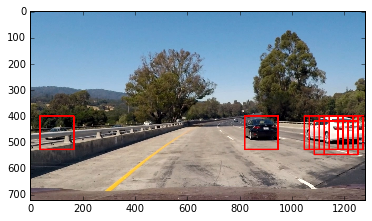

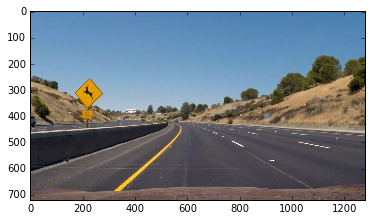

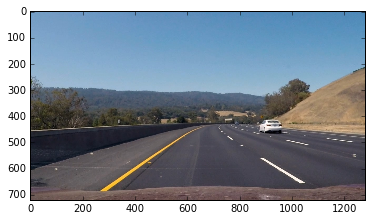

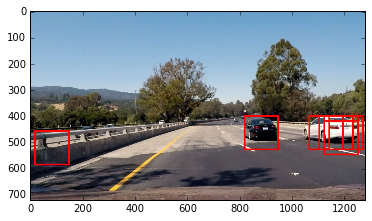

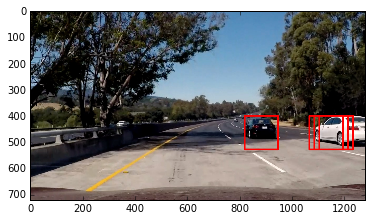

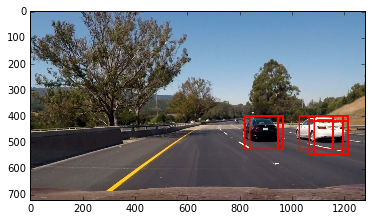

In [9]:
t=time.time() # Start time
for image_p in glob.glob('test_images/test*.jpg'):
    image = cv2.imread(image_p)
    draw_image = np.copy(image)
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 640], 
                    xy_window=(128, 128), xy_overlap=(0.85, 0.85))
    hot_windows = []
    hot_windows += (search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    show_img(window_img)
print(round(time.time()-t, 2), 'Seconds to process test images')

As we can see on examples above, the classifier successfully finds cars on the test images. However, there is a false positive example, so, we will need to apply a kind of filter (such as heat map) and the classifier failed to find a car on th 3rd image because it is too small for it. That is why, we will need to use multi scale windows.

## Advanced Sliding Windows

To increase performance we need to analize the smallest possible number of windows. That is why, we will scan with a search window not across the whole image, but only areas where a new car can appear and also we are going to scan areas where a car was detected (track cars). 
### Detect new cars
On every frame we look for new passing cars (red areas on sides) cars and new far cars (blue area).

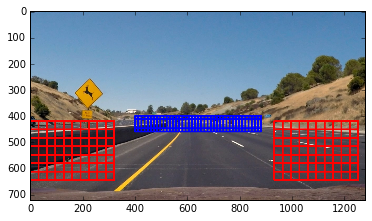

In [10]:
image = cv2.imread('test_images/test2.jpg')
windows = slide_window(image, x_start_stop=[930, None], y_start_stop=[420, 650], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
windows += slide_window(image, x_start_stop=[0, 350], y_start_stop=[420, 650], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6) 
windows = slide_window(image, x_start_stop=[400, 880], y_start_stop=[400, 470], 
                    xy_window=(48, 48), xy_overlap=(0.75, 0.75))
window_img = draw_boxes(window_img, windows, color=(255, 0, 0), thick=6)                    
show_img(window_img)

### Refine detected car position

For every detected car we are doing to scan with a sliding window the ROI around the previous known position. We use multiple scales of windows in order to detect the car and its position more accurate and reliable.

Here is an example with two scales of windows.

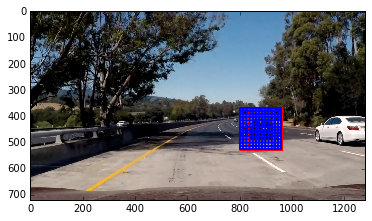

In [11]:
image = cv2.imread('test_images/test5.jpg')
track = (880, 450)
w_size = 80
windows = slide_window(image, x_start_stop=[track[0]-w_size,track[0]+w_size], 
                       y_start_stop=[track[1]-w_size,track[1]+w_size], 
                       xy_window=(128, 128), xy_overlap=(0.75, 0.75))
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)
windows = slide_window(image, x_start_stop=[track[0]-w_size,track[0]+w_size], 
                       y_start_stop=[track[1]-int(w_size),track[1]+int(w_size)], 
                       xy_window=(48, 48), xy_overlap=(0.75, 0.75))
window_img = draw_boxes(window_img, windows, color=(255, 0, 0), thick=6)                    
show_img(window_img)

The following code chunk find windows with a car in a given range with windows of a given scale.

In [12]:
def convert_color(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def find_cars(img, ystart, ystop, xstart, xstop, scale, step):
    boxes = []
    draw_img = np.zeros_like(img)   
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))       
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) -1
    cells_per_step = step  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            # Extract the image patch
            subimg = ctrans_tosearch[ytop:ytop+window, xleft:xleft+window]
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))        
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)+xstart
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
    return boxes

### Lane line function

Here we load a function from the [project 4](https://github.com/PanasheC/Advanced-Lane-Finding) of the Udacity Self-Driving Car Engineer Nanodegree and check if it still works.

In [13]:
import advancedlanefinding

('Corners were found on', '17', 'out of', '20', 'it is', '85.0', '% of calibration images')


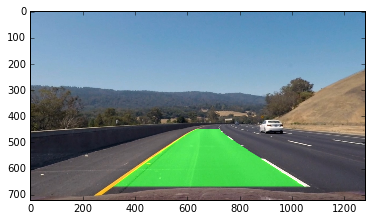

In [16]:
for image in glob.glob('test_images/test3.jpg'):
    show_img(advancedlanefinding.draw_lane(advancedlanefinding.draw_lane_img_p(image)))

## Frames processing

Here we process individual images or videos. To increase performance we skip every 2nd frame because we do not expect very fast moving of the detected cars. We filter all found windows by a heatmap approach (with *THRES* threshold), suggested in lectures.

In order to reduce jitter a function `filt` applies a simple low-pass filter on the new and the previous cars boxes coordinates and sizes.

In [20]:
from scipy.ndimage.measurements import label

THRES = 3 # Minimal overlapping boxes
ALPHA = 0.75 # Filter parameter, weight of the previous measurements

image = cv2.imread('test_images/test1.jpg')
track_list = []#[np.array([880, 440, 76, 76])]
#track_list += [np.array([1200, 480, 124, 124])]
THRES_LEN = 32
Y_MIN = 440

heat_p = np.zeros((720, 1280)) # Store prev heat image
boxes_p = [] # Store prev car boxes
n_count = 0 # Frame counter

<ipython-input-21-491767b0b978>:68: SyntaxWarning: name 'n_count' is used prior to global declaration
  global heat_p, boxes_p, n_count


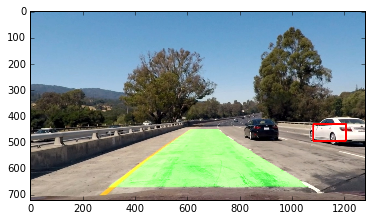

In [21]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap # Return updated heatmap
    
def apply_threshold(heatmap, threshold): # Zero out pixels below the threshold in the heatmap
    heatmap[heatmap < threshold] = 0 
    return heatmap 

def filt(a,b,alpha): # Smooth the car boxes
    return a*alpha+(1.0-alpha)*b

def len_points(p1, p2): # Distance beetween two points
    return np.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)

def track_to_box(p): # Create box coordinates out of its center and span
    return ((int(p[0]-p[2]),int(p[1]-p[3])),(int(p[0]+p[2]), int(p[1]+p[3])))


def draw_labeled_bboxes(labels):
    global track_list
    track_list_l = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        #img = draw_boxes(np.copy(img), [bbox], color=(255,0,255), thick=3)
        size_x = (bbox[1][0]-bbox[0][0])/2.0 #Size of the found box
        size_y = (bbox[1][1]-bbox[0][1])/2.0
        asp_d = size_x / size_y
        size_m = (size_x + size_y)/2
        x = size_x+bbox[0][0]
        y = size_y+bbox[0][1]
        asp = (y-Y_MIN)/130.0+1.2 # Best rectangle aspect ratio for the box (coefficients from perspectieve measurements and experiments)
        if x>1050 or x<230:
            asp*=1.4
        asp = max(asp, asp_d) # for several cars chunk
        size_ya = np.sqrt(size_x*size_y/asp)
        size_xa = int(size_ya*asp)
        size_ya = int(size_ya)
        if x > (-3.049*y+1809): #If the rectangle on the road, coordinates estimated from a test image
            track_list_l.append(np.array([x, y, size_xa, size_ya]))
            if len(track_list) > 0:
                track_l = track_list_l[-1]
                dist = []
                for track in track_list:
                    dist.append(len_points(track, track_l))
                min_d = min(dist)
                if min_d < THRES_LEN:
                    ind = dist.index(min_d)
                    track_list_l[-1] = filt(track_list[ind], track_list_l[-1], ALPHA)
    track_list = track_list_l
    boxes = []
    for track in track_list_l:
        #print(track_to_box(track))
        boxes.append(track_to_box(track))
    return boxes

def frame_proc(img, lane = False, video = False, vis = False):
    if (video and n_count%2==0) or not video: # Skip every second video frame
        global heat_p, boxes_p, n_count
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        boxes = []
        boxes = find_cars(img, 400, 650, 950, 1280, 2.0, 2)
        boxes += find_cars(img, 400, 500, 950, 1280, 1.5, 2)
        boxes += find_cars(img, 400, 650, 0, 330, 2.0, 2)
        boxes += find_cars(img, 400, 500, 0, 330, 1.5, 2)
        boxes += find_cars(img, 400, 460, 330, 950, 0.75, 3)
        for track in track_list:
            y_loc = track[1]+track[3]
            lane_w = (y_loc*2.841-1170.0)/3.0
            if lane_w < 96:
                lane_w = 96
            lane_h = lane_w/1.2
            lane_w = max(lane_w, track[2])
            xs = track[0]-lane_w
            xf = track[0]+lane_w
            if track[1] < Y_MIN:
                track[1] = Y_MIN
            ys = track[1]-lane_h
            yf = track[1]+lane_h
            if xs < 0: xs=0
            if xf > 1280: xf=1280
            if ys < Y_MIN - 40: ys=Y_MIN - 40
            if yf > 720: yf=720
            size_sq = lane_w / (0.015*lane_w+0.3)
            scale = size_sq / 64.0
            # Apply multi scale image windows 
            boxes+=find_cars(img, ys, yf, xs, xf, scale, 2)
            boxes+=find_cars(img, ys, yf, xs, xf, scale*1.25, 2)
            boxes+=find_cars(img, ys, yf, xs, xf, scale*1.5, 2)
            boxes+=find_cars(img, ys, yf, xs, xf, scale*1.75, 2)
            if vis:
                cv2.rectangle(img, (int(xs), int(ys)), (int(xf), int(yf)), color=(0,255,0), thickness=3)
        heat = add_heat(heat, boxes)
        heat_l = heat_p + heat
        heat_p = heat
        heat_l = apply_threshold(heat_l,THRES) # Apply threshold to help remove false positives
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat_l, 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        #print((labels[0]))
        cars_boxes = draw_labeled_bboxes(labels)
        boxes_p = cars_boxes
        
    else:
        cars_boxes = boxes_p
    if lane: #If we was asked to draw the lane line, do it
        if video:
            img = advancedlanefinding.draw_lane(img, True)
        else:
            img = advancedlanefinding.draw_lane(img, False)
    imp = draw_boxes(np.copy(img), cars_boxes, color=(0, 0, 255), thick=6)
    if vis:
        imp = draw_boxes(imp, boxes, color=(0, 255, 255), thick=2)
        for track in track_list:
            cv2.circle(imp, (int(track[0]), int(track[1])), 5, color=(255, 0, 255), thickness=4)
    n_count += 1
    return imp

show_img(frame_proc(image, lane=True, vis=False))

## Video processing

Here we process all three task videos of the project.

Video processing approach with `moviepy` from the [Advanced Lane Line](https://github.com/PanasheC/Advanced-Lane-Finding) of the Udacity Self-Driving Car Nanodegreee.

In [24]:
from moviepy.editor import VideoFileClip
n_count = 0
advancedlanefinding.init_params(0.0)
def process_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return cv2.cvtColor(frame_proc(image, lane=True, video=True, vis=False), cv2.COLOR_BGR2RGB)

output_v = 'project_video_proc.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_image)
%time clip.write_videofile(output_v, audio=False)

[MoviePy] >>>> Building video project_video_proc.mp4
[MoviePy] Writing video project_video_proc.mp4


100%|█████████████████████████████████████▉| 1260/1261 [08:40<00:00,  2.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_proc.mp4 

Wall time: 8min 41s


## Results and discussion

The pipeline is able to correctly detect and lable cars areas on a video frames. I used code from the Advanced Lane Line [Advanced Lane Line](https://github.com/PanasheC/Advanced-Lane-Finding) finding algorithm was added for the lane marking.

- The algorithm may fail in case of difficult light conditions, which could be partly resolved by the classifier improvement. Instead of using a linear SVM classifer I could use a Fast Region based Convolutional Neural Network [Generic Object Tracking](http://cs231n.stanford.edu/reports/2017/pdfs/630.pdf)  Faster R-CNN, with modified  GOTURN  (Generic  Object  Tracking  Using Regression  Networks)  architecture. we  leverage a pre-trained  Faster-RCNN,  one  of  the  popular  and widely used architecture for multi-object detection. This model combines CNN to propose the region of interest and a region-based R-CNN  module that detects the presence of the object in these regions. We freeze the pre-trained weights for the detection network and train the tracking network on the multiple object tracker(MOT) dataset. The advantage of GOTURN is that it is faster than previous approaches and can track the object at 100 fps. Alternative we can use the You Only Look Once (YOLO) to detect the vehicles from a dash camera video stream, and is able to achieve almost real time (35fps) processing.

- It is possible to improve the classifier by additional data augmentation, hard negative mining, classifier parameters tuning etc.

- The algorithm may have some problems in case of car overlaps another. To resolve this problem one may introduce long term memory of car position and a kind of predictive algorithm which can predict where occluded car can be and where it is worth to look for it.

- To eliminate false positives on areas out of the road, one can deeply combine results from the Advanced Lane Line finding project to correctly determine the wide ROI on the whole frame by the road boundaries. Unfortunately, it was not correctly implemented (just hard coded, which is enought for the project but not a good implementation for a real-world application) due to time limitation.

- The pipeline is not a real-time (about 4 fps with Lane line detection, which independently performs at 9 fps). One can further optimize number of features and feature extraction parameters as well as number of analyzed windows to increase the rate because lane line detection is quite fast.  